In [ ]:
from moviepy.editor import VideoFileClip
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Calibrating camera

obj_points = []
img_points = []

nx = 9
ny = 6

cal_paths = glob.glob('./camera_cal/*.jpg')

objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for i, path in enumerate(cal_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny))
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret) 
        #plt.figure(i)
        #plt.imshow(img)
        
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, 
                                                                     gray.shape, None, None) 
print (cameraMatrix)
print (distCoeffs)

In [ ]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

test_paths = glob.glob('./test_images/*.jpg')

for i, path in enumerate(test_paths):
    img = mpimg.imread(path)
    img_undist = cv2.undistort(img, cameraMatrix, distCoeffs)
    #plt.figure(i,figsize=(20,10))
    #plt.subplot(121)
    #plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(img_undist)
    vertices = np.array([[(590,438),(img.shape[1]-590,438),(img.shape[1]-200,671),(200,671)]], dtype=np.int32)
    img_undist = region_of_interest(img_undist, vertices)
    
    img_draw = img_undist.copy()
    src = np.int32([[610,438],[670,438],[1039,671],[285,671]])
    dst = np.int32([[274+50,0],[1032-50,0],[1032-50,img.shape[0]],[274+50,img.shape[0]]])
    cv2.polylines(img_draw, [src], True, (0,255,0),2)
    cv2.polylines(img_draw, [dst], True, (0,0,255),5)

    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    img_warp = cv2.warpPerspective(img_undist, M, (img.shape[1],img.shape[0]))

    plt.figure(i,figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img_draw)
    plt.subplot(122)
    plt.imshow(img_warp)

In [ ]:
from moviepy.editor import VideoFileClip
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def nothing(img):
    pass

cameraMatrix = np.array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
 [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

distCoeffs = np.array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,  -1.28285248e-04,
    2.67027151e-02]])

#cv2.startWindowThread()
cv2.namedWindow('trackbar')
cv2.namedWindow('original')
cv2.namedWindow('blur')
cv2.namedWindow('edge')
cv2.namedWindow('warp')

test_paths = glob.glob('./test_images/*.jpg')
#img = np.zeros((300,512,3), np.uint8)
cv2.createTrackbar('Blur kernel','trackbar',1,5,nothing)
cv2.createTrackbar('Edge detection method','trackbar',0,2,nothing)
cv2.createTrackbar('Edge filter kernel','trackbar',1,5,nothing)
cv2.createTrackbar('Image number','trackbar',0,len(test_paths)-1,nothing)
cv2.createTrackbar('Color space','trackbar',0,1,nothing)
cv2.createTrackbar('Color channel','trackbar',2,2,nothing)

cv2.createTrackbar('Gradient high threshold','trackbar',255,400,nothing)
cv2.createTrackbar('Gradient low threshold','trackbar',20,400,nothing)



# Set initial parameters
cv2.setTrackbarPos('Edge filter kernel','trackbar',2)
cv2.setTrackbarPos('Color channel','trackbar',2)
cv2.setTrackbarPos('Gradient high threshold','trackbar',255)
cv2.setTrackbarPos('Gradient low threshold','trackbar',20)

HLS = 0
HSV = 1
SOBEL = 0
LAPLACE = 1
CANNY = 2

while(1):
    # get current positions of four trackbars
    kernel_size_blur = 3 + 2*cv2.getTrackbarPos('Blur kernel','trackbar')
    edge_method = cv2.getTrackbarPos('Edge detection method','trackbar')
    kernel_size_edge = 3 + 2*cv2.getTrackbarPos('Edge filter kernel','trackbar')
    img_id = cv2.getTrackbarPos('Image number','trackbar')
    color_space = cv2.getTrackbarPos('Color space','trackbar')
    channel = cv2.getTrackbarPos('Color channel','trackbar')
    high_thresh = cv2.getTrackbarPos('Gradient high threshold','trackbar')
    low_thresh = cv2.getTrackbarPos('Gradient low threshold','trackbar')

    img_origin = cv2.imread(test_paths[img_id])
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

    img_undist = cv2.undistort(img_origin, cameraMatrix, distCoeffs)
    #img_undist = img_undist[400:img_undist.shape[0],:,:] # Cropping

    img_blur = cv2.GaussianBlur(img_undist, (kernel_size_blur,kernel_size_blur), 0)

    # Color space conversion
    if (color_space == HLS):
        img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HLS)
    elif (color_space == HSV):
        img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HSV)
    
    img_channel = img_cvtColor[:,:,channel]
    img_bin = np.zeros_like(img_channel)

    if (edge_method == SOBEL):
        sobel_x = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=kernel_size_edge)
        sobel_y = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=kernel_size_edge)
        angle = np.arctan2(sobel_y,sobel_x)
        sobel_x = np.absolute(sobel_x)
        sobel_y = np.absolute(sobel_y)
        img_edge = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
        #img_bin = np.zeros_like(img_edge)
        #img_bin[(img_edge > low_thresh) & (img_edge < high_thresh)] = 255
    elif (edge_method == LAPLACE):
        img_edge = cv2.Laplacian(img_channel,cv2.CV_64F,ksize=kernel_size_edge)
        #img_bin = img_edge
        print ('min value of laplace',np.min(img_edge))
    elif (edge_method == CANNY):
        print(kernel_size_edge)
        img_edge = cv2.Canny(img_channel,low_thresh, high_thresh, apertureSize=kernel_size_edge)
        img_bin = img_edge

    if ((edge_method == SOBEL) | (edge_method == LAPLACE)):
        img_edge = np.asarray(255*img_edge/np.max(img_edge),dtype=np.uint8)
        img_bin[(img_edge > low_thresh) & (img_edge < high_thresh)] = 255
    

    src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
    dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img_origin.shape[0]],[274+100,img_origin.shape[0]]])
    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    img_warp = cv2.warpPerspective(img_bin, M, (img_origin.shape[1],img_origin.shape[0]))
    

    # Resize images
    img_undist = cv2.resize(img_undist,(0,0), fx=0.5,fy=0.5) 
    img_blur = cv2.resize(img_blur,(0,0), fx=0.5,fy=0.5)
    img_bin = cv2.resize(img_bin,(0,0), fx=0.5,fy=0.5)
    img_warp = cv2.resize(img_warp,(0,0), fx=0.5,fy=0.5)

    
    cv2.imshow('original', img_undist)
    cv2.imshow('blur', img_blur)
    cv2.imshow('edge', img_bin)
    cv2.imshow('warp', img_warp)

cv2.destroyAllWindows()

In [ ]:
test_paths = glob.glob('./test_images/*.jpg')

kernel_size=3
low_thresh = 20
high_thresh = 255

for i, path in enumerate(test_paths):
    img = mpimg.imread(path)
    
    img_undist = cv2.undistort(img, cameraMatrix, distCoeffs)
    #img_undist = img_undist[400:img_undist.shape[0],:,:]
    img_hls = cv2.cvtColor(img_undist,cv2.COLOR_RGB2HLS)
    img_sat = img_hls[:,:,2]
    sobel_x = cv2.Sobel(img_sat,cv2.CV_64F,1,0,ksize=kernel_size)
    sobel_y = cv2.Sobel(img_sat,cv2.CV_64F,0,1,ksize=kernel_size)
    #angle = np.arctan2(sobel_y,sobel_x)
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)
    grad = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
    img_bin = np.asarray(255*grad/np.max(grad),dtype=np.uint8)
    img_out = np.zeros_like(img_bin)
    img_out[(img_bin > low_thresh) & (img_bin < high_thresh)] = 255

    img_draw = img.copy()
    src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
    dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img.shape[0]],[274+100,img.shape[0]]])
    cv2.polylines(img_draw, [src], True, (0,255,0),5)
    cv2.polylines(img_draw, [dst], True, (0,0,255),5)
    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    img_warp = cv2.warpPerspective(img_out, M, (img.shape[1],img.shape[0]))

    plt.figure(i,figsize=(20,10))
    plt.subplot(131)
    plt.imshow(img_draw)
    plt.subplot(133)
    plt.imshow(img_warp, cmap='gray')
    plt.subplot(132)
    plt.imshow(img_out, cmap='gray')

#### To-do
- threshold fo color channels

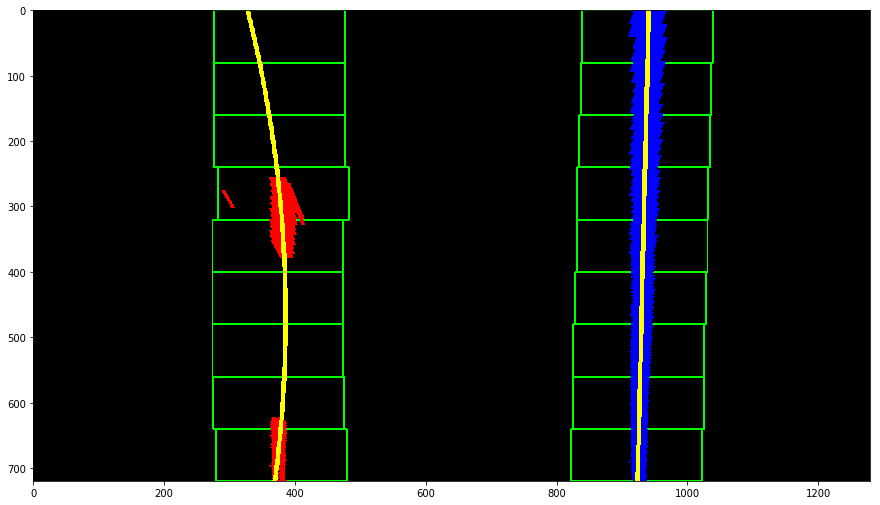

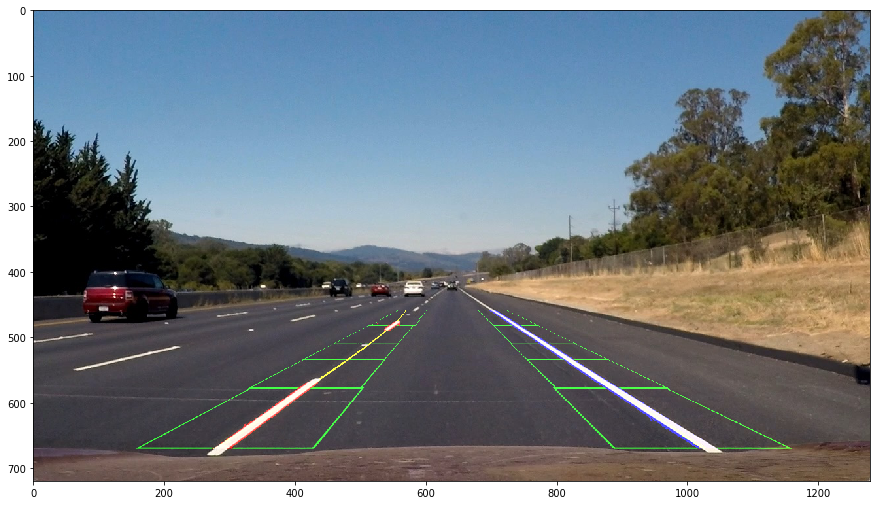

In [1]:
from moviepy.editor import VideoFileClip
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cameraMatrix = np.array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
 [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

distCoeffs = np.array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,  -1.28285248e-04,
    2.67027151e-02]])

img_origin = cv2.imread('./test_images/straight_lines2.jpg')

img_undist = cv2.undistort(img_origin, cameraMatrix, distCoeffs)

img_blur = cv2.GaussianBlur(img_undist, (3,3), 0)

img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HLS)
img_channel = img_cvtColor[:,:,2]
img_bin = np.zeros_like(img_channel)

sobel_x = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=5)
#sobel_y = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=kernel_size_edge)

sobel_x = np.absolute(sobel_x)
#sobel_y = np.absolute(sobel_y)
#img_edge = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
img_edge = sobel_x
img_edge = np.asarray(255*img_edge/np.max(img_edge),dtype=np.uint8)
img_bin[(img_edge > 8) & (img_edge <= 255)] = 255

vertices = np.array([[(520,458),(img_origin.shape[1]-520,458),(img_origin.shape[1]-200,671),(200,671)]], dtype=np.int32)
img_bin = region_of_interest(img_bin, vertices)

src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img_origin.shape[0]],[274+100,img_origin.shape[0]]])
M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
img_warp = cv2.warpPerspective(img_bin, M, (img_origin.shape[1],img_origin.shape[0]))


#plt.figure(figsize=(8,8))
#plt.imshow(cv2.cvtColor(region_of_interest(img_origin, vertices),cv2.COLOR_BGR2RGB))

#plt.figure(figsize=(8,8))
#plt.imshow(img_bin,cmap='gray')

#plt.figure(figsize=(8,8))
#plt.imshow(img_warp,cmap='gray')

# Resize images
#img_undist = cv2.resize(img_undist,(0,0), fx=0.5,fy=0.5) 
#img_blur = cv2.resize(img_blur,(0,0), fx=0.5,fy=0.5)
#img_bin = cv2.resize(img_bin,(0,0), fx=0.5,fy=0.5)
#img_warp = cv2.resize(img_warp,(0,0), fx=0.5,fy=0.5)

#plt.figure(figsize=(8,8))
#histogram = np.sum(img_warp[img_warp.shape[0]/2:,:], axis=0)
#plt.plot(histogram)

binary_warped = img_warp

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
img_poly = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(img_poly,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(img_poly,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)



# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

poly_draw_left = np.dstack((left_fitx,ploty))
poly_draw_left = np.asarray(poly_draw_left, dtype=np.int32)
poly_draw_right = np.dstack((right_fitx,ploty))
poly_draw_right = np.asarray(poly_draw_right, dtype=np.int32)

img_poly[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
img_poly[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

cv2.polylines(img_poly, poly_draw_left, False, (255,255,0),thickness=5)
cv2.polylines(img_poly, poly_draw_right, False, (255,255,0),thickness=5)

plt.figure(figsize=(15,15))
plt.imshow(img_poly)


plt.figure(figsize=(15,15))

M = cv2.getPerspectiveTransform(np.asarray(dst,dtype=np.float32),np.asarray(src,dtype=np.float32))
img_warp = cv2.warpPerspective(img_poly, M, (img_origin.shape[1],img_origin.shape[0]))


img_origin = cv2.cvtColor(img_origin,cv2.COLOR_RGB2BGR)
img_out = cv2.bitwise_or(img_origin,img_warp)

plt.imshow(img_out)


In [34]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

lane_found = False
left_fit = []
right_fit = []

def find_lane(img_origin):
    
    global lane_found, left_fit, right_fit
    
    cameraMatrix = np.array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
         [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
         [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

    distCoeffs = np.array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,  -1.28285248e-04,
            2.67027151e-02]])
    
    img_undist = cv2.undistort(img_origin, cameraMatrix, distCoeffs)

    img_blur = cv2.GaussianBlur(img_undist, (3,3), 0)

    img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HLS)
    img_channel = img_cvtColor[:,:,2]
    img_bin = np.zeros_like(img_channel)

    sobel_x = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=5)
    #sobel_y = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=kernel_size_edge)

    sobel_x = np.absolute(sobel_x)
    #sobel_y = np.absolute(sobel_y)
    #img_edge = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
    img_edge = sobel_x
    img_edge = np.asarray(255*img_edge/np.max(img_edge),dtype=np.uint8)
    img_bin[(img_edge > 10) & (img_edge <= 255)] = 255
    
    #vertices = np.array([[(590,438),(img.shape[1]-590,438),(img.shape[1]-200,671),(200,671)]], dtype=np.int32)
    #img_undist = region_of_interest(img_undist, vertices)
    
    #img_draw = img_undist.copy()
    #src = np.int32([[610,438],[670,438],[1039,671],[285,671]])
    #dst = np.int32([[274+50,0],[1032-50,0],[1032-50,img.shape[1]],[274+50,img.shape[1]]])
    
    
    vertices = np.array([[(520,458),(img_origin.shape[1]-520,458),(img_origin.shape[1]-200,671),(200,671)]], dtype=np.int32)
    #vertices = np.array([[(590,438),(img_origin.shape[1]-590,438),(img_origin.shape[1]-200,671),(200,671)]], dtype=np.int32)
    img_bin = region_of_interest(img_bin, vertices)

    src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
    dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img_origin.shape[0]],[274+100,img_origin.shape[0]]])
    #src = np.int32([[610,438],[670,438],[1039,671],[285,671]])
    #dst = np.int32([[274+50,0],[1032-50,0],[1032-50,img_origin.shape[0]],[274+50,img_origin.shape[0]]])
    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    binary_warped = cv2.warpPerspective(img_bin, M, (img_origin.shape[1],img_origin.shape[0]))

    
    img_poly = np.dstack((binary_warped, binary_warped, binary_warped))*255
    if (lane_found == False):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        img_poly = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(img_poly,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(img_poly,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        lane_found = True
        
    elif (lane_found == True):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]   

    if ((len(lefty) >= 3) & (len(righty) >=3) ):
        lane_found = True
    else:
        lane_found = False
        
    if (lane_found == True):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        print (len(left_fit))
        print (right_fit)
        print (left_fit-right_fit)
        print (np.sum(np.absolute(left_fit-right_fit)))

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        poly_draw_left = np.dstack((left_fitx,ploty))
        poly_draw_left = np.asarray(poly_draw_left, dtype=np.int32)
        poly_draw_right = np.dstack((right_fitx,ploty))
        poly_draw_right = np.asarray(poly_draw_right, dtype=np.int32)

        img_poly[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        img_poly[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

        cv2.polylines(img_poly, poly_draw_left, False, (255,255,0),thickness=5)
        cv2.polylines(img_poly, poly_draw_right, False, (255,255,0),thickness=5)

        M = cv2.getPerspectiveTransform(np.asarray(dst,dtype=np.float32),np.asarray(src,dtype=np.float32))
        img_warp = cv2.warpPerspective(img_poly, M, (img_origin.shape[1],img_origin.shape[0]))
        
        #img_origin = cv2.cvtColor(img_origin,cv2.COLOR_RGB2BGR)
        img_out = cv2.bitwise_or(img_origin,img_warp)
        
        y_eval = 550
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        cv2.putText(img_out, 'Curvature' + str(left_curverad), (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
        

        return img_out
    
    elif (lane_found == False):
        return img_origin


In [ ]:
input_video = 'project_video.mp4'
output_video = 'lane_detection.mp4'
input_clip = VideoFileClip(input_video,audio=False)
output_clip = input_clip.fl_image(find_lane)
%time output_clip.write_videofile(output_video, audio=False)

3
[  1.26445318e-05   1.18907778e-01   9.01387546e+02]
[ -2.18904199e-04   1.34608070e-01  -5.61746053e+02]
561.880879525
[MoviePy] >>>> Building video lane_detection.mp4
[MoviePy] Writing video lane_detection.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]






  0%|          | 1/1261 [00:00<02:44,  7.68it/s]

3
[  1.26445318e-05   1.18907778e-01   9.01387546e+02]
[ -2.18904199e-04   1.34608070e-01  -5.61746053e+02]
561.880879525









  0%|          | 2/1261 [00:00<02:57,  7.10it/s]

3
[ -1.21666125e-04   2.35801175e-01   8.76807579e+02]
[ -9.88836656e-05   3.00730493e-02  -5.38544788e+02]
538.574959679









  0%|          | 3/1261 [00:00<02:55,  7.15it/s]

3
[ -7.45511675e-05   1.88985330e-01   8.85050549e+02]
[ -1.50711045e-04   8.35976220e-02  -5.48284812e+02]
548.368559893









  0%|          | 4/1261 [00:00<02:58,  7.03it/s]

3
[ -1.10284435e-04   2.24318728e-01   8.75536937e+02]
[ -1.18794664e-04   5.30001867e-02  -5.39871087e+02]
539.924206336









  0%|          | 5/1261 [00:00<02:55,  7.18it/s]

3
[ -9.13118300e-05   1.99095921e-01   8.82315926e+02]
[ -1.40064470e-04   8.20654499e-02  -5.47639777e+02]
547.721982315









  0%|          | 6/1261 [00:00<02:55,  7.14it/s]

3
[ -6.26732204e-05   1.59012758e-01   8.91609614e+02]
[ -1.79548692e-04   1.37780594e-01  -5.61328032e+02]
561.4659925









  1%|          | 7/1261 [00:00<02:55,  7.13it/s]

3
[  7.33155011e-05   5.26667731e-02   9.14849859e+02]
[ -2.92766929e-04   2.32087566e-01  -5.85362885e+02]
585.595265665









  1%|          | 8/1261 [00:01<02:57,  7.05it/s]

3
[ -1.15310469e-04   2.53799183e-01   8.60394605e+02]
[ -1.02865825e-04   3.34825281e-02  -5.31317702e+02]
531.351287079









  1%|          | 9/1261 [00:01<03:00,  6.94it/s]

3
[ -8.94587417e-05   2.23917727e-01   8.70147998e+02]
[ -1.07868090e-04   4.88018860e-02  -5.41092709e+02]
541.141619248









  1%|          | 10/1261 [00:01<03:01,  6.88it/s]

3
[ -1.69031059e-04   2.98832114e-01   8.52699220e+02]
[ -2.39406275e-05  -2.62237677e-02  -5.25811489e+02]
525.837736903









  1%|          | 11/1261 [00:01<02:59,  6.97it/s]

3
[ -3.20800318e-04   4.20874632e-01   8.28875981e+02]
[  1.40364790e-04  -1.54656689e-01  -5.02563580e+02]
502.718376961









  1%|          | 12/1261 [00:01<02:57,  7.05it/s]

3
[ -2.48699646e-04   3.51481957e-01   8.50793098e+02]
[  7.66643705e-05  -8.33739591e-02  -5.31432972e+02]
531.516422558









  1%|          | 13/1261 [00:01<02:56,  7.08it/s]

3
[ -1.67154716e-04   2.99442402e-01   8.53012121e+02]
[  1.57182756e-05  -4.67329326e-02  -5.31868609e+02]
531.915357188









  1%|          | 14/1261 [00:02<02:56,  7.05it/s]

3
[ -2.01263180e-05   1.79817294e-01   8.70818195e+02]
[ -1.23939468e-04   6.73631580e-02  -5.48820407e+02]
548.887894523









  1%|          | 15/1261 [00:02<02:57,  7.00it/s]

3
[  4.97723151e-05   1.22209120e-01   8.73752515e+02]
[ -2.06970687e-04   1.33791894e-01  -5.51804362e+02]
551.938361004









  1%|▏         | 16/1261 [00:02<02:56,  7.04it/s]

3
[ -4.79117917e-05   2.14831372e-01   8.48559191e+02]
[ -1.24004078e-04   5.16293220e-02  -5.27314297e+02]
527.36605003









  1%|▏         | 17/1261 [00:02<02:54,  7.11it/s]

3
[  2.25823330e-05   1.40581885e-01   8.64460981e+02]
[ -1.88753555e-04   1.18991458e-01  -5.42472529e+02]
542.591708748









  1%|▏         | 18/1261 [00:02<02:53,  7.17it/s]

3
[  1.23850203e-04   2.78594887e-02   8.90895929e+02]
[ -2.94320488e-04   2.34385069e-01  -5.69231836e+02]
569.466515343









  2%|▏         | 19/1261 [00:02<02:54,  7.13it/s]

3
[  1.35116793e-04  -1.51339342e-02   9.11326259e+02]
[ -2.92965320e-04   2.68636844e-01  -5.90912030e+02]
591.180959709









  2%|▏         | 20/1261 [00:02<02:53,  7.17it/s]

3
[  5.36610444e-04  -3.75844711e-01   9.95422844e+02]
[ -6.87266945e-04   6.24742221e-01  -6.76650293e+02]
677.275722245









  2%|▏         | 21/1261 [00:02<02:52,  7.18it/s]

3
[  4.16688293e-04  -3.04567855e-01   9.92867518e+02]
[ -5.62841116e-04   5.50625839e-01  -6.75843950e+02]
676.395138389









  2%|▏         | 22/1261 [00:03<02:53,  7.15it/s]

3
[  4.70971645e-04  -3.82742037e-01   1.02304394e+03]
[ -5.95068540e-04   6.13482562e-01  -7.07016435e+02]
707.630512437









  2%|▏         | 23/1261 [00:03<02:53,  7.15it/s]

3
[  3.91874923e-04  -3.31445691e-01   1.02082838e+03]
[ -5.28519858e-04   5.71506834e-01  -7.08542739e+02]
709.114774154









  2%|▏         | 24/1261 [00:03<02:53,  7.12it/s]

3
[  8.62906700e-05  -2.40910747e-02   9.43833114e+02]
[ -2.20383548e-04   2.55733921e-01  -6.27696969e+02]
627.95292368









  2%|▏         | 25/1261 [00:03<02:51,  7.20it/s]

3
[ -1.49820299e-04   2.15625475e-01   8.83913102e+02]
[ -2.25436323e-06   2.66822743e-02  -5.68139774e+02]
568.166458724









  2%|▏         | 26/1261 [00:03<02:52,  7.17it/s]

3
[ -2.70785794e-04   3.55202192e-01   8.48434261e+02]
[  1.39630613e-04  -1.29604772e-01  -5.32352918e+02]
532.482662115









  2%|▏         | 27/1261 [00:03<02:53,  7.10it/s]

3
[ -2.43176440e-04   3.31347428e-01   8.55260543e+02]
[  1.05549643e-04  -1.02738029e-01  -5.39900592e+02]
540.003435995









  2%|▏         | 28/1261 [00:03<02:57,  6.96it/s]

3
[ -2.79410788e-04   3.65542892e-01   8.52105203e+02]
[  1.33541610e-04  -1.29243422e-01  -5.40430475e+02]
540.559851507









  2%|▏         | 29/1261 [00:04<02:57,  6.96it/s]

3
[ -1.99935664e-04   3.03950482e-01   8.57638433e+02]
[  4.40643328e-05  -6.36712949e-02  -5.44233289e+02]
544.297004392









  2%|▏         | 30/1261 [00:04<02:55,  7.01it/s]

3
[ -2.44674992e-04   3.62379270e-01   8.36936936e+02]
[  6.01200812e-05  -1.06028832e-01  -5.22079881e+02]
522.185969794









  2%|▏         | 31/1261 [00:04<03:00,  6.80it/s]

3
[ -1.84891925e-04   3.00936421e-01   8.47956246e+02]
[ -3.33971473e-05  -2.51786961e-02  -5.30648071e+02]
530.673282796









  3%|▎         | 32/1261 [00:04<03:00,  6.79it/s]

3
[ -1.89366449e-04   2.99051869e-01   8.45315520e+02]
[ -5.71529534e-05  -1.65131963e-03  -5.28464678e+02]
528.466386333









  3%|▎         | 33/1261 [00:04<02:58,  6.88it/s]

3
[  3.66887480e-04  -2.27141664e-01   9.72507864e+02]
[ -6.12010942e-04   5.22097156e-01  -6.55790055e+02]
656.312763893









  3%|▎         | 34/1261 [00:04<03:00,  6.79it/s]

3
[  3.11213333e-04  -1.95557517e-01   9.69697005e+02]
[ -5.68293181e-04   5.01038485e-01  -6.53171024e+02]
653.672630797









  3%|▎         | 35/1261 [00:05<03:01,  6.77it/s]

3
[ -1.37579411e-04   2.72988656e-01   8.49769983e+02]
[ -1.31604493e-04   4.16124085e-02  -5.33711115e+02]
533.75285853









  3%|▎         | 36/1261 [00:05<03:00,  6.78it/s]

3
[  1.61587366e-04  -7.70414781e-02   9.48171955e+02]
[ -4.41564506e-04   4.07389628e-01  -6.35010010e+02]
635.417841681









  3%|▎         | 37/1261 [00:05<02:56,  6.93it/s]

3
[ -1.88391781e-04   3.34336088e-01   8.28090010e+02]
[ -9.77683843e-05   1.37769976e-03  -5.15059944e+02]
515.061419845









  3%|▎         | 38/1261 [00:05<02:56,  6.91it/s]

3
[ -3.21306458e-04   4.52495990e-01   8.03391171e+02]
[  3.60507008e-05  -1.15032103e-01  -4.90166322e+02]
490.281390177









  3%|▎         | 39/1261 [00:05<02:54,  7.01it/s]

3
[ -1.92893974e-04   3.58989509e-01   8.11809707e+02]
[ -1.14058302e-04  -2.91216072e-03  -5.00886593e+02]
500.889619514









  3%|▎         | 40/1261 [00:05<02:52,  7.06it/s]

3
[ -1.92375163e-04   3.54081916e-01   8.15561394e+02]
[ -1.04054076e-04   8.50049473e-05  -5.07245356e+02]
507.245544897









  3%|▎         | 41/1261 [00:05<02:53,  7.01it/s]

3
[ -1.26731118e-04   2.87382330e-01   8.30950990e+02]
[ -1.62545869e-04   6.38385020e-02  -5.22934474e+02]
522.998474579









  3%|▎         | 42/1261 [00:05<02:51,  7.10it/s]

3
[ -1.13336943e-04   2.64699044e-01   8.39708534e+02]
[ -1.81429734e-04   9.36586822e-02  -5.33635364e+02]
533.729204368









  3%|▎         | 43/1261 [00:06<03:01,  6.71it/s]

3
[ -8.21493639e-05   2.27273012e-01   8.51172770e+02]
[ -2.03433709e-04   1.28533760e-01  -5.46741460e+02]
546.870196985


3
[  3.06662629e-05   8.29452800e-02   8.94428182e+02]
[ -3.07060919e-04   2.70541805e-01  -5.92627284e+02]
592.898132926









  3%|▎         | 44/1261 [00:06<03:13,  6.29it/s]






  4%|▎         | 45/1261 [00:06<03:10,  6.38it/s]

3
[ -1.11758371e-05   1.25562096e-01   8.87897929e+02]
[ -2.43972811e-04   2.16125047e-01  -5.86906419e+02]
587.122788284









  4%|▎         | 46/1261 [00:06<03:04,  6.60it/s]

3
[  3.54361559e-04  -2.09059813e-01   9.65148253e+02]
[ -5.99458067e-04   5.43026879e-01  -6.63558764e+02]
664.102390222









  4%|▎         | 47/1261 [00:06<03:02,  6.67it/s]

3
[  2.11011032e-04  -8.49839773e-02   9.41416469e+02]
[ -4.41737278e-04   4.10778005e-01  -6.40858326e+02]
641.269545823









  4%|▍         | 48/1261 [00:06<03:04,  6.59it/s]

3
[  2.67625808e-04  -1.66392453e-01   9.66830558e+02]
[ -4.89929843e-04   4.86668372e-01  -6.65934400e+02]
666.421558134









  4%|▍         | 49/1261 [00:07<03:05,  6.53it/s]

3
[  1.87951731e-05   7.08035244e-02   9.14121065e+02]
[ -2.21711081e-04   2.37769607e-01  -6.14342912e+02]
614.580903071









  4%|▍         | 50/1261 [00:07<03:07,  6.46it/s]

3
[  5.44247379e-04  -5.02292020e-01   1.07039521e+03]
[ -7.31404629e-04   8.00581700e-01  -7.70354272e+02]
771.155585485









  4%|▍         | 51/1261 [00:07<03:05,  6.54it/s]

3
[ -1.56059652e-04   2.85790135e-01   8.49417910e+02]
[ -1.41617989e-05   5.46207329e-04  -5.48624437e+02]
548.62499753









  4%|▍         | 52/1261 [00:07<03:06,  6.48it/s]

3
[ -1.90518353e-04   3.43737089e-01   8.25142189e+02]
[  2.24368091e-05  -5.96711961e-02  -5.23326134e+02]
523.385827766









  4%|▍         | 53/1261 [00:07<03:10,  6.34it/s]

3
[ -1.83714103e-04   3.44400399e-01   8.19976454e+02]
[  1.73179426e-05  -6.58358492e-02  -5.15854522e+02]
515.920375128









  4%|▍         | 54/1261 [00:07<03:13,  6.22it/s]

3
[ -2.17886789e-04   3.83892452e-01   8.06888583e+02]
[  5.23515083e-05  -1.02994250e-01  -5.04955441e+02]
505.058488092


3
[ -1.48182058e-04   3.07999730e-01   8.26570319e+02]
[  3.91704252e-06  -4.69629106e-02  -5.22100561e+02]
522.147527975









  4%|▍         | 55/1261 [00:08<03:22,  5.96it/s]

3
[ -8.55354992e-05   2.33205181e-01   8.47357982e+02]
[ -4.92228604e-05   1.81396418e-02  -5.41842686e+02]
541.860875308









  4%|▍         | 56/1261 [00:08<03:26,  5.83it/s]






  5%|▍         | 57/1261 [00:08<03:22,  5.95it/s]

3
[ -6.79437218e-05   2.00065803e-01   8.57941329e+02]
[ -7.20480385e-05   5.39000412e-02  -5.52297138e+02]
552.351110009









  5%|▍         | 58/1261 [00:08<03:20,  6.01it/s]

3
[  1.83573220e-04  -3.21007413e-03   9.00150276e+02]
[ -3.25701440e-04   2.57226498e-01  -5.95078069e+02]
595.335621344


3
[  3.60058167e-04  -1.96007180e-01   9.46140294e+02]
[ -5.27841797e-04   4.63905078e-01  -6.39306075e+02]
639.770508039









  5%|▍         | 59/1261 [00:08<03:21,  5.97it/s]






  5%|▍         | 60/1261 [00:08<03:14,  6.19it/s]

3
[ -1.34117360e-04   3.15166610e-01   8.10988764e+02]
[ -3.55985647e-05  -5.14393633e-02  -5.00356766e+02]
500.408241066









  5%|▍         | 61/1261 [00:09<03:13,  6.21it/s]

3
[ -5.87950683e-05   2.79127439e-01   8.07212645e+02]
[ -1.11998933e-04  -2.12629037e-02  -4.93291853e+02]
493.313227915


3
[ -1.13690497e-04   3.27575629e-01   7.93962199e+02]
[ -5.80139029e-05  -7.24859537e-02  -4.77673911e+02]
477.74645495









  5%|▍         | 62/1261 [00:09<03:18,  6.04it/s]






  5%|▍         | 63/1261 [00:09<03:16,  6.09it/s]

3
[ -5.29081603e-05   2.67343743e-01   8.08503600e+02]
[ -1.25457452e-04  -8.33007449e-03  -4.93665662e+02]
493.674117763









  5%|▌         | 64/1261 [00:09<03:19,  5.99it/s]

3
[  3.99929765e-06   2.11563999e-01   8.18839321e+02]
[ -1.88119252e-04   4.76079504e-02  -5.02094234e+02]
502.142029618









  5%|▌         | 65/1261 [00:09<03:19,  6.00it/s]

3
[ -1.13334053e-05   2.06676119e-01   8.26351766e+02]
[ -1.96567621e-04   7.13770900e-02  -5.13993321e+02]
514.064894773









  5%|▌         | 66/1261 [00:09<03:17,  6.06it/s]

3
[ -2.72284698e-07   1.87091976e-01   8.31244238e+02]
[ -1.93177000e-04   7.63862281e-02  -5.14926014e+02]
515.002593785


3
[  4.97941049e-05   1.22989170e-01   8.49409185e+02]
[ -2.46562994e-04   1.38745989e-01  -5.32130367e+02]
532.269359157









  5%|▌         | 67/1261 [00:10<03:20,  5.96it/s]

3
[  6.03757904e-05   9.97936354e-02   8.59195569e+02]
[ -2.45164950e-04   1.51371819e-01  -5.41113168e+02]
541.264785202









  5%|▌         | 68/1261 [00:10<03:24,  5.84it/s]






  5%|▌         | 69/1261 [00:10<03:19,  5.98it/s]

3
[  1.48575386e-04  -3.35494229e-03   8.85352036e+02]
[ -3.24522216e-04   2.46818360e-01  -5.65095749e+02]
565.342892086









  6%|▌         | 70/1261 [00:10<03:21,  5.91it/s]

3
[ -1.57167261e-04   2.98367234e-01   8.17284657e+02]
[ -1.71554250e-05  -5.37499172e-02  -4.99978582e+02]
500.032349238









  6%|▌         | 71/1261 [00:10<03:19,  5.96it/s]

3
[  6.26175063e-04  -4.54111359e-01   9.95978560e+02]
[ -7.94918031e-04   6.93208999e-01  -6.77170419e+02]
677.864423282









  6%|▌         | 72/1261 [00:10<03:15,  6.09it/s]

3
[ -1.02728722e-04   2.43554913e-01   8.32138973e+02]
[ -3.78128907e-05  -2.32234841e-02  -5.13216992e+02]
513.240253722


3
[ -3.83946694e-05   1.95729073e-01   8.40449408e+02]
[ -1.07317426e-04   3.15572899e-02  -5.24554917e+02]
524.586581966









  6%|▌         | 73/1261 [00:11<03:20,  5.94it/s]






  6%|▌         | 74/1261 [00:11<03:13,  6.13it/s]

3
[ -3.22347690e-05   1.82677438e-01   8.44396805e+02]
[ -9.40483551e-05   2.98741016e-02  -5.26998535e+02]
527.028503381









  6%|▌         | 75/1261 [00:11<03:16,  6.04it/s]

3
[ -7.64705014e-05   2.11690087e-01   8.43182284e+02]
[ -4.35512423e-05  -3.62457023e-03  -5.27447110e+02]
527.450778458









  6%|▌         | 76/1261 [00:11<03:17,  6.01it/s]

3
[ -4.19750405e-05   1.81027297e-01   8.48256217e+02]
[ -7.50521016e-05   2.32545434e-02  -5.31419101e+02]
531.442430655


3
[ -1.77591367e-04   2.93274300e-01   8.33072479e+02]
[  6.37894609e-05  -8.80271678e-02  -5.21118073e+02]
521.206163972









  6%|▌         | 77/1261 [00:11<03:18,  5.96it/s]

3
[ -3.82486567e-05   1.62773753e-01   8.60974407e+02]
[ -3.35002111e-05   6.08196178e-03  -5.43736777e+02]
543.742892392









  6%|▌         | 78/1261 [00:11<03:20,  5.91it/s]






  6%|▋         | 79/1261 [00:12<03:19,  5.91it/s]

3
[ -2.19028530e-06   1.16003358e-01   8.75447728e+02]
[ -7.46081680e-05   5.29729190e-02  -5.58825951e+02]
558.878998153









  6%|▋         | 80/1261 [00:12<03:17,  5.99it/s]

3
[ -1.13662571e-05   1.19278975e-01   8.75924399e+02]
[ -4.87397816e-05   3.14108941e-02  -5.55674329e+02]
555.705788571


3
[  6.10824401e-05   4.15419871e-02   8.93166143e+02]
[ -1.42978526e-04   1.21201587e-01  -5.73148940e+02]
573.270284575









  6%|▋         | 81/1261 [00:12<03:21,  5.85it/s]

3
[  4.59655327e-05   4.56195232e-02   8.96921130e+02]
[ -1.36094158e-04   1.21555863e-01  -5.78745985e+02]
578.867676483









  7%|▋         | 82/1261 [00:12<03:20,  5.87it/s]

3
[  2.56085520e-04  -1.27226908e-01   9.34021579e+02]
[ -3.51772791e-04   2.95852047e-01  -6.15884822e+02]
616.181026006









  7%|▋         | 83/1261 [00:12<03:23,  5.79it/s]






  7%|▋         | 84/1261 [00:12<03:17,  5.95it/s]

3
[  2.89306365e-04  -1.91368661e-01   9.62439323e+02]
[ -3.82402032e-04   3.58754577e-01  -6.48073788e+02]
648.432925369









  7%|▋         | 85/1261 [00:13<03:16,  5.98it/s]

3
[  2.74132236e-04  -1.97037914e-01   9.70004136e+02]
[ -3.82235110e-04   3.73350833e-01  -6.55751020e+02]
656.124752716


3
[ -1.60538398e-04   2.64163426e-01   8.49676830e+02]
[  4.31616468e-05  -8.35731212e-02  -5.34599993e+02]
534.683609412









  7%|▋         | 86/1261 [00:13<03:18,  5.93it/s]






  7%|▋         | 87/1261 [00:13<03:18,  5.91it/s]

3
[ -1.31652838e-04   2.54377871e-01   8.42018786e+02]
[ -1.76913059e-05  -5.77919290e-02  -5.22034814e+02]
522.092623349


3
[ -1.63760814e-04   2.97617431e-01   8.24481954e+02]
[ -3.19825931e-08  -9.47144600e-02  -5.00752487e+02]
500.847201868









  7%|▋         | 88/1261 [00:13<03:23,  5.77it/s]






  7%|▋         | 89/1261 [00:13<03:17,  5.93it/s]

3
[ -1.81214630e-04   3.19391339e-01   8.15902016e+02]
[ -1.00456125e-05  -9.86876441e-02  -4.91257286e+02]
491.35598347









  7%|▋         | 90/1261 [00:13<03:18,  5.89it/s]

3
[ -7.74697444e-05   2.40550674e-01   8.22313636e+02]
[ -1.32131013e-04  -9.63427490e-03  -4.94063713e+02]
494.073479752


3
[ -1.14351124e-04   2.61791393e-01   8.24522744e+02]
[ -8.66095053e-05  -3.73430541e-02  -4.95799912e+02]
495.837341725









  7%|▋         | 91/1261 [00:14<03:17,  5.91it/s]






  7%|▋         | 92/1261 [00:14<03:17,  5.93it/s]

3
[ -1.11830829e-04   2.51192377e-01   8.29982145e+02]
[ -7.55429369e-05  -3.64959819e-02  -4.99898589e+02]
499.93516093









  7%|▋         | 93/1261 [00:14<03:18,  5.89it/s]

3
[ -1.15197493e-04   2.57088126e-01   8.26076843e+02]
[ -9.08967243e-05  -3.06110318e-02  -4.94884162e+02]
494.914864182


3
[  1.70469463e-04  -5.46477553e-02   9.03842832e+02]
[ -3.79216546e-04   2.85656672e-01  -5.72828347e+02]
573.114382546









  7%|▋         | 94/1261 [00:14<03:23,  5.73it/s]

3
[ -8.83819534e-05   2.13956754e-01   8.40734758e+02]
[ -1.16868892e-04   1.65869518e-02  -5.11487582e+02]
511.504285557









  8%|▊         | 95/1261 [00:14<03:22,  5.77it/s]

3
[ -2.79390188e-04   3.74805959e-01   8.08280031e+02]
[  7.94547800e-05  -1.47050880e-01  -4.79012432e+02]
479.159562313









  8%|▊         | 96/1261 [00:14<03:18,  5.86it/s]






  8%|▊         | 97/1261 [00:15<03:18,  5.88it/s]

3
[ -2.61099151e-04   3.55926118e-01   8.13418681e+02]
[  8.65909000e-05  -1.45733574e-01  -4.81541622e+02]
481.687442405









  8%|▊         | 98/1261 [00:15<03:16,  5.91it/s]

3
[ -2.52163063e-04   3.50513544e-01   8.17598471e+02]
[  6.78121398e-05  -1.31408637e-01  -4.88507120e+02]
488.63859654









  8%|▊         | 99/1261 [00:15<03:13,  6.00it/s]

3
[ -2.12951751e-04   3.32479543e-01   8.15151447e+02]
[  3.04275647e-05  -1.11252999e-01  -4.86035179e+02]
486.146462406


3
[ -1.67684638e-04   2.88566460e-01   8.27051286e+02]
[  4.79414689e-06  -8.11994009e-02  -4.96896265e+02]
496.977469094









  8%|▊         | 100/1261 [00:15<03:20,  5.79it/s]

3
[ -1.94280660e-04   3.08299246e-01   8.24641194e+02]
[  3.18139877e-05  -1.00047434e-01  -4.93920316e+02]
494.020394752









  8%|▊         | 101/1261 [00:15<03:22,  5.73it/s]






  8%|▊         | 102/1261 [00:16<03:19,  5.81it/s]

3
[ -2.15906641e-04   3.33189060e-01   8.16550407e+02]
[  3.33960215e-05  -1.08681880e-01  -4.86821697e+02]
486.930412752









  8%|▊         | 103/1261 [00:16<03:17,  5.87it/s]

3
[ -1.73473433e-04   2.88985886e-01   8.29389268e+02]
[ -1.12154096e-05  -6.34003507e-02  -4.99209351e+02]
499.272762402









  8%|▊         | 104/1261 [00:16<03:15,  5.93it/s]

3
[ -1.19054603e-04   2.35315305e-01   8.41707396e+02]
[ -7.68069895e-05  -1.70339514e-03  -5.11519298e+02]
511.521078685









  8%|▊         | 105/1261 [00:16<03:14,  5.94it/s]

3
[ -6.90845831e-05   1.71578094e-01   8.64883620e+02]
[ -1.08129604e-04   4.83084096e-02  -5.35021812e+02]
535.070228048


3
[ -2.43118147e-05   1.17666644e-01   8.82612976e+02]
[ -1.41952316e-04   9.56186949e-02  -5.52955767e+02]
553.051527612









  8%|▊         | 106/1261 [00:16<03:16,  5.88it/s]

3
[  2.75736578e-06   7.58469208e-02   9.00546279e+02]
[ -1.90018655e-04   1.56754311e-01  -5.75218796e+02]
575.375740121









  8%|▊         | 107/1261 [00:16<03:17,  5.85it/s]






  9%|▊         | 108/1261 [00:16<03:06,  6.19it/s]

3
[  1.70544175e-04  -5.25046340e-02   9.23856985e+02]
[ -3.84021206e-04   3.03860410e-01  -5.97766428e+02]
598.070671953









  9%|▊         | 109/1261 [00:17<03:06,  6.17it/s]

3
[  2.18961799e-04  -1.08976172e-01   9.40773710e+02]
[ -4.33134804e-04   3.60878989e-01  -6.14483222e+02]
614.844534007


3
[  2.76484884e-04  -1.90309551e-01   9.68609181e+02]
[ -4.88329886e-04   4.40220787e-01  -6.41439998e+02]
641.880706809









  9%|▊         | 110/1261 [00:17<03:14,  5.91it/s]

3
[  2.22924623e-04  -1.46520626e-01   9.60668677e+02]
[ -4.50536643e-04   4.09740183e-01  -6.34572524e+02]
634.982714696









  9%|▉         | 111/1261 [00:17<03:14,  5.91it/s]






  9%|▉         | 112/1261 [00:17<03:14,  5.92it/s]

3
[  7.98742416e-05  -2.34546531e-02   9.40545048e+02]
[ -2.82426395e-04   2.69437088e-01  -6.14265257e+02]
614.534976644









  9%|▉         | 113/1261 [00:17<03:14,  5.91it/s]

3
[ -2.46806449e-04   3.35422496e-01   8.40813869e+02]
[  2.89139777e-05  -7.77073840e-02  -5.13734466e+02]
513.812201873









  9%|▉         | 114/1261 [00:18<03:10,  6.02it/s]

3
[ -2.02382714e-04   3.02480652e-01   8.46059164e+02]
[ -2.52875145e-05  -3.68535017e-02  -5.19224017e+02]
519.260895656


3
[ -8.02168059e-05   1.97665167e-01   8.63700312e+02]
[ -1.62511044e-04   7.80263695e-02  -5.35405643e+02]
535.483832233









  9%|▉         | 115/1261 [00:18<03:14,  5.91it/s]






  9%|▉         | 116/1261 [00:18<03:12,  5.96it/s]

3
[ -5.08549190e-05   1.77249967e-01   8.63117388e+02]
[ -2.04352163e-04   1.10686984e-01  -5.36588157e+02]
536.699048026









  9%|▉         | 117/1261 [00:18<03:08,  6.06it/s]

3
[ -1.02583031e-04   2.19600221e-01   8.57147529e+02]
[ -1.52824092e-04   6.78886474e-02  -5.30639953e+02]
530.707994056









  9%|▉         | 118/1261 [00:18<03:09,  6.02it/s]

3
[ -4.90407077e-05   1.60752197e-01   8.71908685e+02]
[ -2.11190864e-04   1.33083086e-01  -5.46766060e+02]
546.899354596


3
[ -2.81355477e-05   1.32720022e-01   8.80899301e+02]
[ -2.29939504e-04   1.61664839e-01  -5.56106337e+02]
556.268231993









  9%|▉         | 119/1261 [00:18<03:17,  5.77it/s]






 10%|▉         | 120/1261 [00:19<03:12,  5.93it/s]

3
[ -7.89798093e-05   1.88480138e-01   8.65486857e+02]
[ -1.70056728e-04   1.01266787e-01  -5.38616892e+02]
538.718328895









 10%|▉         | 121/1261 [00:19<03:07,  6.08it/s]

3
[  2.84854879e-04  -1.55830366e-01   9.49258570e+02]
[ -5.35102299e-04   4.49720003e-01  -6.24092791e+02]
624.543046409


3
[  2.23300534e-04  -1.07522540e-01   9.40942333e+02]
[ -4.64416320e-04   3.96885502e-01  -6.15230422e+02]
615.627771487









 10%|▉         | 122/1261 [00:19<03:15,  5.83it/s]

3
[ -2.04019494e-04   3.39139367e-01   8.23940835e+02]
[ -5.58969086e-05  -3.41635929e-02  -4.99026725e+02]
499.060944132









 10%|▉         | 123/1261 [00:19<03:18,  5.74it/s]






 10%|▉         | 124/1261 [00:19<03:14,  5.84it/s]

3
[  2.63650805e-04  -1.85190800e-01   9.69615042e+02]
[ -5.09918014e-04   4.80178884e-01  -6.42824285e+02]
643.30497372









 10%|▉         | 125/1261 [00:19<03:09,  5.99it/s]

3
[ -2.73421016e-04   3.99571247e-01   8.11897940e+02]
[  3.57525919e-05  -1.09439877e-01  -4.84385896e+02]
484.495371467


3
[  3.96737248e-04  -3.67726089e-01   1.03489802e+03]
[ -6.25228086e-04   6.55381835e-01  -7.10534600e+02]
711.19060692









 10%|▉         | 126/1261 [00:20<03:12,  5.88it/s]

3
[ -2.37213597e-04   3.73416969e-01   8.18989226e+02]
[  1.17233442e-05  -8.59089405e-02  -4.94597247e+02]
494.683167925









 10%|█         | 127/1261 [00:20<03:12,  5.88it/s]






 10%|█         | 128/1261 [00:20<03:10,  5.96it/s]

3
[ -2.16912130e-04   3.60361967e-01   8.21056547e+02]
[  2.05014849e-05  -9.29963734e-02  -4.94884946e+02]
494.977962934









 10%|█         | 129/1261 [00:20<03:09,  5.98it/s]

3
[ -1.92544363e-04   3.55360392e-01   8.12205682e+02]
[ -8.49364297e-06  -8.38914633e-02  -4.84472477e+02]
484.556376723


3
[ -2.79472672e-04   4.36145726e-01   7.96049289e+02]
[  7.58088549e-05  -1.64300151e-01  -4.68409120e+02]
468.573495611









 10%|█         | 130/1261 [00:20<03:12,  5.88it/s]

3
[ -3.32941790e-04   5.02259746e-01   7.76254266e+02]
[  1.32844141e-04  -2.33694843e-01  -4.47614619e+02]
447.848447133









 10%|█         | 131/1261 [00:20<03:12,  5.88it/s]

3
[ -1.56516229e-04   3.10667295e-01   8.23161782e+02]
[ -4.51351386e-05  -4.20317650e-02  -4.92543999e+02]
492.586075479









 10%|█         | 132/1261 [00:21<03:17,  5.73it/s]






 11%|█         | 133/1261 [00:21<03:11,  5.90it/s]

3
[ -1.17108376e-04   2.45301990e-01   8.47135236e+02]
[ -8.69151005e-05   2.68216568e-02  -5.17847797e+02]
517.874705851


3
[  5.76155530e-06   1.42279090e-01   8.69269016e+02]
[ -2.07456904e-04   1.28649274e-01  -5.39372083e+02]
539.500940028









 11%|█         | 134/1261 [00:21<03:16,  5.73it/s]

3
[  6.42029505e-05   6.70702933e-02   8.94223822e+02]
[ -2.55564242e-04   1.97357192e-01  -5.63765374e+02]
563.962986585









 11%|█         | 135/1261 [00:21<03:14,  5.79it/s]






 11%|█         | 136/1261 [00:21<03:10,  5.90it/s]

3
[  1.15554951e-04   2.82713725e-03   9.16683040e+02]
[ -2.91318410e-04   2.47910159e-01  -5.83850007e+02]
584.098208655


3
[ -8.93139920e-05   2.02933387e-01   8.70872666e+02]
[ -7.54072787e-05   3.69612724e-02  -5.36669304e+02]
536.706340802









 11%|█         | 137/1261 [00:21<03:18,  5.68it/s]

3
[  6.80692852e-04  -6.48591417e-01   1.10955983e+03]
[ -8.40317707e-04   8.84383941e-01  -7.75735139e+02]
776.620363628









 11%|█         | 138/1261 [00:22<03:16,  5.72it/s]






 11%|█         | 139/1261 [00:22<03:12,  5.83it/s]

3
[ -1.48397145e-04   2.69187137e-01   8.57266819e+02]
[ -9.69430364e-06  -3.39959931e-02  -5.24425372e+02]
524.459377556


3
[ -9.80524185e-05   2.13669373e-01   8.74906140e+02]
[ -6.02176838e-05   2.18711498e-02  -5.44425348e+02]
544.447278941









 11%|█         | 140/1261 [00:22<03:11,  5.86it/s]

3
[ -1.78697156e-04   3.09976811e-01   8.45466068e+02]
[  2.34872716e-05  -7.79067033e-02  -5.14114676e+02]
514.192606518









 11%|█         | 141/1261 [00:22<03:15,  5.72it/s]

3
[ -1.24120050e-04   2.56750785e-01   8.55440543e+02]
[ -3.69922302e-05  -2.33431817e-02  -5.23630211e+02]
523.653590894









 11%|█▏        | 142/1261 [00:22<03:13,  5.78it/s]






 11%|█▏        | 143/1261 [00:22<03:13,  5.78it/s]

3
[ -4.82917443e-05   1.88277582e-01   8.64665148e+02]
[ -1.19811991e-04   4.73715412e-02  -5.30896014e+02]
530.943505035


3
[  2.11753139e-06   1.23995448e-01   8.81761843e+02]
[ -1.72900752e-04   1.13453376e-01  -5.48497547e+02]
548.611173118









 11%|█▏        | 144/1261 [00:23<03:15,  5.72it/s]

3
[  7.45665542e-05   2.45589580e-02   9.11703558e+02]
[ -2.44782140e-04   2.13430477e-01  -5.79313189e+02]
579.526864604









 11%|█▏        | 145/1261 [00:23<03:17,  5.66it/s]

3
[  1.80224493e-04  -4.16320876e-02   9.21474546e+02]
[ -3.44638905e-04   2.70372046e-01  -5.84999035e+02]
585.269751991









 12%|█▏        | 146/1261 [00:23<03:12,  5.78it/s]

3
[  2.06413235e-04  -6.39653849e-02   9.29232150e+02]
[ -3.53519289e-04   2.78909630e-01  -5.90968464e+02]
591.247727019









 12%|█▏        | 147/1261 [00:23<03:13,  5.74it/s]

3
[  1.24533900e-04   1.20698995e-02   9.06745472e+02]
[ -2.89387692e-04   2.11571331e-01  -5.64160763e+02]
564.372623424









 12%|█▏        | 148/1261 [00:23<03:20,  5.54it/s]

3
[  6.99939445e-05   5.66113793e-02   8.98960154e+02]
[ -2.42907437e-04   1.71014867e-01  -5.56061210e+02]
556.232467479









 12%|█▏        | 149/1261 [00:24<03:15,  5.68it/s]

3
[  1.77571625e-04  -7.44830277e-02   9.40549525e+02]
[ -3.40648522e-04   2.96508569e-01  -5.98954233e+02]
599.251082575









 12%|█▏        | 150/1261 [00:24<03:15,  5.68it/s]

3
[ -1.60125187e-05   1.68274544e-01   8.66186911e+02]
[ -1.42396678e-04   5.14015538e-02  -5.25704995e+02]
525.756539193









 12%|█▏        | 151/1261 [00:24<03:18,  5.59it/s]






 12%|█▏        | 152/1261 [00:24<03:09,  5.84it/s]

3
[  2.53610495e-05   1.16529037e-01   8.81913418e+02]
[ -1.62376541e-04   8.65229445e-02  -5.40758832e+02]
540.845517255









 12%|█▏        | 153/1261 [00:24<03:03,  6.05it/s]

3
[ -8.09393415e-05   2.23807479e-01   8.52746023e+02]
[ -7.03417458e-05  -1.12427514e-02  -5.11458745e+02]
511.470057829









 12%|█▏        | 154/1261 [00:24<03:02,  6.06it/s]

3
[ -8.92127732e-05   2.15312432e-01   8.63119088e+02]
[ -5.63419424e-05  -5.48077052e-03  -5.24766952e+02]
524.77248942


3
[ -1.42385604e-04   2.58487963e-01   8.57529973e+02]
[ -1.91532908e-05  -3.40381735e-02  -5.24161363e+02]
524.195420459









 12%|█▏        | 155/1261 [00:25<03:08,  5.86it/s]






 12%|█▏        | 156/1261 [00:25<03:03,  6.03it/s]

3
[ -1.24362766e-04   2.39031592e-01   8.61004882e+02]
[ -4.91548594e-05  -5.80500536e-03  -5.29525965e+02]
529.531819525


3
[ -3.57877511e-05   1.37627697e-01   8.86469941e+02]
[ -1.24364708e-04   8.77441746e-02  -5.56069145e+02]
556.157013529









 12%|█▏        | 157/1261 [00:25<03:05,  5.94it/s]

3
[ -7.53840696e-05   1.79092719e-01   8.71260804e+02]
[ -1.16224380e-04   6.76414306e-02  -5.41539843e+02]
541.607600822









 13%|█▎        | 158/1261 [00:25<03:11,  5.75it/s]

3
[  4.41180167e-04  -2.93775305e-01   9.81441132e+02]
[ -6.20395366e-04   5.31756357e-01  -6.53050505e+02]
653.582881274









 13%|█▎        | 159/1261 [00:25<03:09,  5.81it/s]

3
[  4.01335081e-04  -2.71900578e-01   9.78434820e+02]
[ -6.18291564e-04   5.40970205e-01  -6.55417548e+02]
655.95913634









 13%|█▎        | 160/1261 [00:25<03:15,  5.64it/s]

3
[  8.36385305e-05   3.13266772e-02   9.10072473e+02]
[ -2.74285704e-04   2.23362090e-01  -5.89260337e+02]
589.483973291









 13%|█▎        | 161/1261 [00:26<03:15,  5.62it/s]

3
[ -4.39589210e-05   1.44252477e-01   8.86930214e+02]
[ -1.40673411e-04   1.08611230e-01  -5.68265938e+02]
568.374690261









 13%|█▎        | 162/1261 [00:26<03:16,  5.60it/s]

3
[ -3.00830094e-04   4.09599975e-01   8.21500845e+02]
[  1.16481919e-04  -1.52777402e-01  -5.06631180e+02]
506.784074121









 13%|█▎        | 163/1261 [00:26<03:11,  5.72it/s]






 13%|█▎        | 164/1261 [00:26<03:09,  5.78it/s]

3
[ -2.72529677e-04   4.09566136e-01   8.10628262e+02]
[  9.76889661e-05  -1.63169562e-01  -4.92355816e+02]
492.519083196


3
[ -2.40016821e-04   3.95470021e-01   8.04487020e+02]
[  6.36391932e-05  -1.51078234e-01  -4.83332203e+02]
483.483345103









 13%|█▎        | 165/1261 [00:26<03:06,  5.88it/s]

3
[ -1.51015785e-04   3.17132761e-01   8.18486440e+02]
[ -2.51368673e-05  -6.84265481e-02  -5.01033434e+02]
501.101885716









 13%|█▎        | 166/1261 [00:26<03:05,  5.89it/s]

3
[ -8.40228905e-05   2.53540986e-01   8.28565308e+02]
[ -1.12686180e-04   9.03731135e-03  -5.11704397e+02]
511.713546864









 13%|█▎        | 167/1261 [00:27<03:06,  5.86it/s]






 13%|█▎        | 168/1261 [00:27<03:00,  6.06it/s]

3
[ -1.12050452e-04   2.64931282e-01   8.34679457e+02]
[ -5.54293455e-05  -2.12378879e-02  -5.18866474e+02]
518.887767507


3
[ -2.52383271e-05   1.61203664e-01   8.64106793e+02]
[ -1.20833943e-04   6.89981711e-02  -5.49145876e+02]
549.214995356









 13%|█▎        | 169/1261 [00:27<03:07,  5.81it/s]






 13%|█▎        | 170/1261 [00:27<02:59,  6.07it/s]

3
[  6.54090578e-05   3.29779816e-02   9.05622624e+02]
[ -2.08569619e-04   2.00714391e-01  -5.96089839e+02]
596.290761869


3
[  3.77684735e-04  -2.62686870e-01   9.76871092e+02]
[ -5.17294141e-04   4.92693256e-01  -6.67473851e+02]
667.967061567









 14%|█▎        | 171/1261 [00:27<03:11,  5.69it/s]

3
[  2.90384459e-04  -1.94138728e-01   9.64580141e+02]
[ -4.35995202e-04   4.29799947e-01  -6.57436758e+02]
657.866993446









 14%|█▎        | 172/1261 [00:27<03:14,  5.60it/s]

3
[  4.09340504e-04  -3.34601068e-01   1.00348633e+03]
[ -5.61130145e-04   5.74883597e-01  -6.96932627e+02]
697.508072083









 14%|█▎        | 173/1261 [00:28<03:10,  5.73it/s]

3
[  3.89889346e-04  -3.27879348e-01   1.00250723e+03]
[ -5.62130086e-04   5.80373889e-01  -6.95331095e+02]
695.912031266









 14%|█▍        | 174/1261 [00:28<03:10,  5.69it/s]

3
[  1.63573454e-04  -9.85406658e-02   9.44638596e+02]
[ -3.58768157e-04   3.69047681e-01  -6.39919865e+02]
640.289271725









 14%|█▍        | 175/1261 [00:28<03:10,  5.70it/s]

3
[ -1.83163156e-04   3.09559821e-01   8.25791798e+02]
[ -2.31270114e-05  -3.27060780e-02  -5.21613527e+02]
521.646255946









 14%|█▍        | 176/1261 [00:28<03:10,  5.71it/s]

3
[ -2.83814561e-04   4.10151487e-01   8.04991805e+02]
[  1.04590446e-04  -1.51072075e-01  -5.02237896e+02]
502.389072255









 14%|█▍        | 177/1261 [00:28<03:10,  5.69it/s]

3
[ -2.19673708e-04   3.49515606e-01   8.20817368e+02]
[  3.94044283e-05  -9.16081049e-02  -5.17727637e+02]
517.819284784









 14%|█▍        | 178/1261 [00:29<03:11,  5.66it/s]

3
[ -2.10192662e-04   3.39843544e-01   8.25245787e+02]
[  1.05413252e-05  -7.06672506e-02  -5.23098311e+02]
523.16898885









 14%|█▍        | 179/1261 [00:29<03:10,  5.68it/s]

3
[ -3.56873933e-04   4.79892107e-01   7.99654820e+02]
[  1.43839342e-04  -2.00822610e-01  -4.99430608e+02]
499.631574279









 14%|█▍        | 180/1261 [00:29<03:10,  5.66it/s]

3
[ -2.50356083e-04   3.82806983e-01   8.16810230e+02]
[  3.09159969e-05  -1.05622539e-01  -5.11516186e+02]
511.621839091









 14%|█▍        | 181/1261 [00:29<03:17,  5.48it/s]

3
[ -2.40559845e-04   3.58140946e-01   8.29119544e+02]
[  1.35387792e-05  -7.63612916e-02  -5.25293171e+02]
525.369545505









 14%|█▍        | 182/1261 [00:29<03:10,  5.68it/s]

3
[ -4.83655636e-05   1.94532506e-01   8.61136643e+02]
[ -1.97088971e-04   9.65045239e-02  -5.54865674e+02]
554.962375688









 15%|█▍        | 183/1261 [00:29<03:10,  5.66it/s]

3
[  3.66323714e-05   1.23308097e-01   8.73106517e+02]
[ -2.88015547e-04   1.68383256e-01  -5.63940559e+02]
564.109230068









 15%|█▍        | 184/1261 [00:30<03:15,  5.50it/s]

3
[  2.20115725e-04  -1.08152635e-01   9.39912779e+02]
[ -4.77318046e-04   4.03064872e-01  -6.28705127e+02]
629.108669651









 15%|█▍        | 185/1261 [00:30<03:19,  5.39it/s]

3
[  5.28859003e-05   8.97870746e-02   8.78342062e+02]
[ -3.49535773e-04   2.34460544e-01  -5.66630252e+02]
566.865061926









 15%|█▍        | 186/1261 [00:30<03:23,  5.29it/s]

3
[ -2.18935107e-04   3.81581928e-01   8.01489603e+02]
[ -8.65850030e-05  -4.59663570e-02  -4.92191155e+02]
492.23720786









 15%|█▍        | 187/1261 [00:30<03:13,  5.54it/s]

3
[  3.33878069e-04  -2.37365128e-01   9.73134043e+02]
[ -6.45079682e-04   5.80974087e-01  -6.63891068e+02]
664.472687613









 15%|█▍        | 188/1261 [00:30<03:17,  5.44it/s]

3
[ -2.63731404e-04   4.61813633e-01   7.69171524e+02]
[ -4.28108638e-05  -1.19632860e-01  -4.59716368e+02]
459.836043186









 15%|█▍        | 189/1261 [00:31<03:19,  5.38it/s]






 15%|█▌        | 190/1261 [00:31<03:11,  5.60it/s]

3
[ -2.62262497e-04   4.65856297e-01   7.66396162e+02]
[ -3.23795640e-05  -1.28930304e-01  -4.56360667e+02]
456.489629637


3
[ -4.04972342e-04   6.29703039e-01   7.19365985e+02]
[  8.82016757e-05  -2.73256236e-01  -4.10872988e+02]
411.146332189









 15%|█▌        | 191/1261 [00:31<03:08,  5.66it/s]

3
[ -3.97318282e-04   6.18143212e-01   7.24819621e+02]
[  1.04706097e-04  -2.75722736e-01  -4.16080131e+02]
416.355958711









 15%|█▌        | 192/1261 [00:31<03:13,  5.52it/s]






 15%|█▌        | 193/1261 [00:31<03:16,  5.43it/s]

3
[ -2.66366248e-04   4.90751582e-01   7.50263651e+02]
[ -2.94584133e-07  -1.67269129e-01  -4.37006277e+02]
437.173546351
3
[ -2.10455040e-04   4.17969166e-01   7.72269725e+02]
[ -7.45321538e-05  -7.59449719e-02  -4.63061521e+02]
463.137540185









 15%|█▌        | 194/1261 [00:31<03:17,  5.40it/s]






 15%|█▌        | 195/1261 [00:32<03:16,  5.42it/s]

3
[ -5.02975815e-05   2.41298218e-01   8.20606117e+02]
[ -2.25589664e-04   9.40029743e-02  -5.10746363e+02]
510.840591607
3
[  1.62196694e-04  -1.67859003e-04   8.96388501e+02]
[ -3.98708663e-04   3.09274542e-01  -5.88619541e+02]
588.929214722









 16%|█▌        | 196/1261 [00:32<03:10,  5.58it/s]






 16%|█▌        | 197/1261 [00:32<03:08,  5.65it/s]

3
[  2.26730851e-04  -9.09434297e-02   9.32960959e+02]
[ -4.32149743e-04   3.83605565e-01  -6.30027590e+02]
630.411628183
3
[  2.02823030e-04  -1.03383228e-01   9.52316657e+02]
[ -3.93296083e-04   3.89268182e-01  -6.54761578e+02]
655.151239661









 16%|█▌        | 198/1261 [00:32<03:07,  5.67it/s]






 16%|█▌        | 199/1261 [00:32<02:57,  6.00it/s]

3
[ -1.01025678e-05   8.67631046e-02   9.17252616e+02]
[ -1.69805814e-04   1.95637015e-01  -6.25150160e+02]
625.345966883
3
[  7.05731187e-04  -6.89754656e-01   1.12610469e+03]
[ -8.86988684e-04   9.72350166e-01  -8.34295371e+02]
835.268608532









 16%|█▌        | 200/1261 [00:32<03:05,  5.72it/s]






 16%|█▌        | 201/1261 [00:33<03:01,  5.83it/s]

3
[  8.10747783e-04  -8.57608093e-01   1.18820107e+03]
[ -9.74040482e-04   1.12442759e+00  -8.95967495e+02]
897.092896537
3
[ -9.36880762e-05   2.05363262e-01   8.73529322e+02]
[ -8.26283103e-05   6.53540471e-02  -5.78950893e+02]
579.01632918









 16%|█▌        | 202/1261 [00:33<03:01,  5.83it/s]






 16%|█▌        | 203/1261 [00:33<03:01,  5.84it/s]






 16%|█▌        | 204/1261 [00:33<02:57,  5.96it/s]

3
[ -1.86806917e-04   3.21954209e-01   8.34697844e+02]
[  1.25425327e-05  -5.55221425e-02  -5.38226875e+02]
538.28240966
3
[ -3.05557341e-04   4.38789519e-01   8.08372890e+02]
[  1.32886231e-04  -1.75778711e-01  -5.11640855e+02]
511.816766185









 16%|█▋        | 205/1261 [00:33<03:02,  5.78it/s]

3
[ -1.15757293e-04   2.62416767e-01   8.38851770e+02]
[ -6.82802669e-05   5.43977793e-03  -5.39496239e+02]
539.501747009
3
[ -7.02338874e-05   2.11005575e-01   8.50918816e+02]
[ -1.20089335e-04   5.86948815e-02  -5.49598509e+02]
549.657324091









 16%|█▋        | 206/1261 [00:34<03:02,  5.79it/s]






 16%|█▋        | 207/1261 [00:34<02:54,  6.05it/s]

3
[ -1.07060113e-04   2.51784031e-01   8.34917041e+02]
[ -1.17620325e-04   4.23956633e-02  -5.32838178e+02]
532.880691267
3
[ -5.81180222e-05   2.08674395e-01   8.42122935e+02]
[ -1.80734086e-04   9.42146917e-02  -5.38855187e+02]
538.949582445









 16%|█▋        | 208/1261 [00:34<02:58,  5.90it/s]






 17%|█▋        | 209/1261 [00:34<03:05,  5.68it/s]






 17%|█▋        | 210/1261 [00:34<03:01,  5.79it/s]

3
[  2.42668016e-04  -7.18676952e-02   9.11707015e+02]
[ -4.59907616e-04   3.60782904e-01  -6.08327951e+02]
608.689193504
3
[  2.85145562e-04  -1.64866375e-01   9.49916817e+02]
[ -4.88687262e-04   4.46452827e-01  -6.48081388e+02]
648.528329174









 17%|█▋        | 211/1261 [00:34<03:04,  5.70it/s]






 17%|█▋        | 212/1261 [00:35<03:01,  5.79it/s]

3
[ -1.90555241e-04   3.32803110e-01   8.26205911e+02]
[ -1.21282386e-05  -5.08233468e-02  -5.26842690e+02]
526.893525363
3
[ -3.21832110e-04   4.51344596e-01   7.99809573e+02]
[  1.19251445e-04  -1.70133416e-01  -4.99301699e+02]
499.471951229









 17%|█▋        | 213/1261 [00:35<03:02,  5.73it/s]






 17%|█▋        | 214/1261 [00:35<02:55,  5.96it/s]

3
[ -3.36765182e-04   4.67626174e-01   7.95770779e+02]
[  1.24566184e-04  -1.78912795e-01  -4.96950851e+02]
497.129887922
3
[ -2.73945322e-04   4.27680461e-01   7.96838010e+02]
[  5.59834462e-05  -1.33856477e-01  -4.98829009e+02]
498.962921169









 17%|█▋        | 215/1261 [00:35<03:00,  5.80it/s]

3
[ -1.76459642e-04   3.49240505e-01   8.06169839e+02]
[ -6.05341744e-05  -3.79218363e-02  -5.12289687e+02]
512.327669658
3
[ -2.01909866e-04   3.74200461e-01   7.98903745e+02]
[ -2.06810661e-05  -7.19770034e-02  -5.05807197e+02]
505.87919429









 17%|█▋        | 216/1261 [00:35<03:03,  5.71it/s]






 17%|█▋        | 217/1261 [00:35<03:09,  5.51it/s]






 17%|█▋        | 218/1261 [00:36<03:01,  5.73it/s]

3
[ -1.73092185e-04   3.46388722e-01   8.02156376e+02]
[ -6.11234571e-05  -3.31892532e-02  -5.11518287e+02]
511.551537458
3
[ -1.39667219e-04   3.00991584e-01   8.17125267e+02]
[ -7.20790443e-05  -1.16689713e-03  -5.28068163e+02]
528.069402337









 17%|█▋        | 219/1261 [00:36<02:59,  5.79it/s]






 17%|█▋        | 220/1261 [00:36<02:54,  5.98it/s]

3
[ -4.74208817e-05   2.09659813e-01   8.33408212e+02]
[ -1.67557918e-04   9.17714241e-02  -5.42904859e+02]
542.996797912
3
[  2.89396083e-07   1.64346549e-01   8.48067824e+02]
[ -1.94818404e-04   1.25909840e-01  -5.60275028e+02]
560.401132838









 18%|█▊        | 221/1261 [00:36<02:55,  5.91it/s]






 18%|█▊        | 222/1261 [00:36<02:53,  5.98it/s]

3
[  7.69740754e-05   8.11408666e-02   8.69921239e+02]
[ -2.61600625e-04   2.05244194e-01  -5.83440167e+02]
583.64567259
3
[  3.35930825e-05   1.20937380e-01   8.60775483e+02]
[ -2.19948985e-04   1.66517812e-01  -5.74594479e+02]
574.761216471









 18%|█▊        | 223/1261 [00:36<02:58,  5.80it/s]






 18%|█▊        | 224/1261 [00:37<02:52,  6.01it/s]

3
[ -6.06759286e-05   2.21995296e-01   8.34443898e+02]
[ -1.14754056e-04   5.79888743e-02  -5.48175115e+02]
548.233218223
3
[ -1.15181230e-04   2.95103122e-01   8.06538288e+02]
[ -6.21090494e-05  -1.68763586e-02  -5.16827453e+02]
516.844391019









 18%|█▊        | 225/1261 [00:37<02:53,  5.98it/s]

3
[  1.76741523e-05   1.76745348e-01   8.30942292e+02]
[ -1.81514324e-04   9.27948958e-02  -5.41854422e+02]
541.947397976
3
[ -4.15280795e-05   2.35210295e-01   8.12372894e+02]
[ -1.26407868e-04   3.35303857e-02  -5.21135692e+02]
521.169348574









 18%|█▊        | 226/1261 [00:37<02:54,  5.93it/s]






 18%|█▊        | 227/1261 [00:37<02:58,  5.79it/s]

3
[  5.87592975e-05   1.27387642e-01   8.38746212e+02]
[ -2.18337056e-04   1.34993760e-01  -5.48177336e+02]
548.312548326
3
[  7.25549202e-05   9.48367840e-02   8.51746713e+02]
[ -2.33473042e-04   1.70425064e-01  -5.64668532e+02]
564.83919057









 18%|█▊        | 228/1261 [00:37<03:07,  5.51it/s]






 18%|█▊        | 229/1261 [00:37<03:05,  5.55it/s]






 18%|█▊        | 230/1261 [00:38<02:58,  5.79it/s]

3
[  8.27712143e-05   7.03415323e-02   8.60179689e+02]
[ -2.35992481e-04   1.84662761e-01  -5.70770045e+02]
570.954943316
3
[  4.31557857e-05   9.51299603e-02   8.60688737e+02]
[ -1.96757751e-04   1.62743480e-01  -5.75576751e+02]
575.739691538









 18%|█▊        | 231/1261 [00:38<02:59,  5.74it/s]

3
[  6.73340191e-05   6.08881440e-02   8.70243117e+02]
[ -2.23108419e-04   1.98018274e-01  -5.85267438e+02]
585.465679055
3
[  9.14358674e-05   3.26306127e-02   8.81121594e+02]
[ -2.42871806e-04   2.25602479e-01  -6.00174911e+02]
600.400756543









 18%|█▊        | 232/1261 [00:38<03:02,  5.65it/s]






 18%|█▊        | 233/1261 [00:38<03:04,  5.58it/s]






 19%|█▊        | 234/1261 [00:38<02:58,  5.76it/s]

3
[  2.52684775e-04  -1.24863516e-01   9.18932677e+02]
[ -3.96733605e-04   3.76253068e-01  -6.37620140e+02]
637.996789841
3
[ -9.43034705e-05   2.34405897e-01   8.27050177e+02]
[ -5.63688392e-05   1.98075241e-02  -5.46623404e+02]
546.643267758









 19%|█▊        | 235/1261 [00:39<03:05,  5.53it/s]

3
[ -1.03033667e-04   2.37163704e-01   8.27341736e+02]
[ -5.32191976e-05   1.74211669e-02  -5.46513244e+02]
546.530718494
3
[ -1.34517888e-04   2.82717408e-01   8.07928928e+02]
[ -1.70679332e-05  -3.36510363e-02  -5.24175361e+02]
524.209028835









 19%|█▊        | 236/1261 [00:39<03:01,  5.66it/s]






 19%|█▉        | 237/1261 [00:39<02:52,  5.93it/s]

3
[ -3.25449067e-04   4.63313258e-01   7.67266850e+02]
[  1.65188255e-04  -2.08785399e-01  -4.84909045e+02]
485.117996084
3
[ -3.01846530e-04   4.51946430e-01   7.65780650e+02]
[  1.23623345e-04  -1.86286395e-01  -4.83862654e+02]
484.049064081









 19%|█▉        | 238/1261 [00:39<02:55,  5.82it/s]






 19%|█▉        | 239/1261 [00:39<02:52,  5.92it/s]

3
[ -2.51151291e-04   4.13857388e-01   7.69499593e+02]
[  6.65907505e-05  -1.48055524e-01  -4.85669730e+02]
485.81785254
3
[ -1.36509594e-04   3.06176001e-01   7.92547493e+02]
[ -4.42828207e-05  -4.57204507e-02  -5.08376616e+02]
508.422380672









 19%|█▉        | 240/1261 [00:39<02:55,  5.83it/s]






 19%|█▉        | 241/1261 [00:40<02:54,  5.84it/s]

3
[ -3.56562899e-05   1.93114700e-01   8.20937132e+02]
[ -1.57438052e-04   7.59470058e-02  -5.37569482e+02]
537.645586289
3
[  1.71338772e-05   1.24858776e-01   8.44704223e+02]
[ -2.06340929e-04   1.42645384e-01  -5.64429310e+02]
564.57216149









 19%|█▉        | 242/1261 [00:40<02:57,  5.73it/s]






 19%|█▉        | 243/1261 [00:40<03:03,  5.56it/s]






 19%|█▉        | 244/1261 [00:40<02:58,  5.71it/s]

3
[ -3.72665704e-05   1.83590049e-01   8.28037617e+02]
[ -1.58015597e-04   8.53150551e-02  -5.44639323e+02]
544.72479562
3
[ -5.55827106e-05   1.92346232e-01   8.29913351e+02]
[ -1.31548636e-04   7.07111788e-02  -5.47171794e+02]
547.242636509









 19%|█▉        | 245/1261 [00:40<02:59,  5.67it/s]

3
[  2.65355859e-05   1.18823815e-01   8.44147445e+02]
[ -2.16242759e-04   1.42417571e-01  -5.58954874e+02]
559.097507808
3
[  1.23702295e-04   1.89598862e-02   8.68606495e+02]
[ -3.29389421e-04   2.52471494e-01  -5.83742745e+02]
583.995545741









 20%|█▉        | 246/1261 [00:40<02:59,  5.64it/s]






 20%|█▉        | 247/1261 [00:41<03:01,  5.59it/s]

3
[  1.55958742e-04  -2.77858334e-02   8.85605116e+02]
[ -3.71195237e-04   3.06787203e-01  -6.02555534e+02]
602.862692157
3
[  1.21395476e-04   5.76269127e-03   8.75030903e+02]
[ -3.38693167e-04   2.71987726e-01  -5.88569182e+02]
588.841508566









 20%|█▉        | 248/1261 [00:41<02:57,  5.70it/s]






 20%|█▉        | 249/1261 [00:41<03:01,  5.57it/s]

3
[ -2.34916305e-04   4.08454275e-01   7.64593320e+02]
[  1.80242279e-05  -1.28997669e-01  -4.80759700e+02]
480.888715591
3
[ -1.86706208e-04   3.56169421e-01   7.77912585e+02]
[ -4.00303461e-05  -7.08649503e-02  -4.93515417e+02]
493.586322014









 20%|█▉        | 250/1261 [00:41<03:04,  5.49it/s]






 20%|█▉        | 251/1261 [00:41<03:08,  5.35it/s]

3
[ -2.49210940e-04   4.19520723e-01   7.63691778e+02]
[  2.68715316e-05  -1.37228104e-01  -4.79897543e+02]
480.034798418
3
[ -1.11701222e-04   2.76660314e-01   7.99192346e+02]
[ -1.06922039e-04   3.94424915e-04  -5.14409718e+02]
514.410219141









 20%|█▉        | 252/1261 [00:42<03:03,  5.51it/s]






 20%|██        | 253/1261 [00:42<03:03,  5.49it/s]

3
[ -1.10253282e-04   2.70438616e-01   8.01146258e+02]
[ -1.01828782e-04  -2.90255527e-04  -5.14371156e+02]
514.371548228
3
[ -6.85258184e-05   2.15693858e-01   8.19982864e+02]
[ -1.31491911e-04   4.49546172e-02  -5.32856851e+02]
532.901936846









 20%|██        | 254/1261 [00:42<03:02,  5.50it/s]






 20%|██        | 255/1261 [00:42<03:05,  5.44it/s]






 20%|██        | 256/1261 [00:42<02:58,  5.63it/s]

3
[ -2.62447783e-05   1.70154514e-01   8.30182585e+02]
[ -1.68535530e-04   8.07597998e-02  -5.37516952e+02]
537.597880098
3
[  1.29451068e-05   1.14953910e-01   8.48558408e+02]
[ -2.22053355e-04   1.46696860e-01  -5.56926510e+02]
557.073428425









 20%|██        | 257/1261 [00:42<03:01,  5.53it/s]

3
[  2.14536101e-04  -5.95666134e-02   8.86820820e+02]
[ -4.22143176e-04   3.15739359e-01  -5.90961388e+02]
591.277549327
3
[  1.60355652e-04  -1.65589541e-02   8.79165122e+02]
[ -3.64087776e-04   2.66598231e-01  -5.79786058e+02]
580.053019863









 20%|██        | 258/1261 [00:43<03:03,  5.47it/s]






 21%|██        | 259/1261 [00:43<03:09,  5.29it/s]

3
[ -7.98848616e-05   2.22617588e-01   8.23063266e+02]
[ -1.10530215e-04   1.77857183e-02  -5.22462524e+02]
522.480420702
3
[ -1.90474816e-04   3.39002572e-01   7.92102834e+02]
[  1.15001998e-07  -1.01493317e-01  -4.87713072e+02]
487.814565181









 21%|██        | 260/1261 [00:43<03:07,  5.34it/s]






 21%|██        | 261/1261 [00:43<03:12,  5.21it/s]

3
[ -9.41005951e-05   2.26312175e-01   8.28934109e+02]
[ -7.19844028e-05  -9.53995229e-03  -5.22067828e+02]
522.07744031









 21%|██        | 262/1261 [00:43<03:15,  5.11it/s]

3
[ -2.81144084e-04   3.97984316e-01   7.92761353e+02]
[  1.07680555e-04  -1.79237590e-01  -4.83242670e+02]
483.422015536









 21%|██        | 263/1261 [00:44<03:16,  5.09it/s]

3
[ -2.28698367e-04   3.43158448e-01   8.08471128e+02]
[  7.76083531e-05  -1.46574756e-01  -4.93700447e+02]
493.847099801
3
[ -1.63246935e-04   2.86917712e-01   8.19858611e+02]
[  1.79086161e-05  -9.91230207e-02  -5.02824958e+02]
502.924099224









 21%|██        | 264/1261 [00:44<03:13,  5.16it/s]






 21%|██        | 265/1261 [00:44<03:11,  5.20it/s]

3
[ -6.86866880e-05   1.86005988e-01   8.45670101e+02]
[ -8.54513275e-05   7.12882591e-03  -5.28858105e+02]
528.865319631
3
[ -7.26175615e-05   1.75567204e-01   8.56381304e+02]
[ -8.09796154e-05   1.86900380e-02  -5.42283521e+02]
542.302291747









 21%|██        | 266/1261 [00:44<03:06,  5.34it/s]






 21%|██        | 267/1261 [00:44<03:05,  5.35it/s]

3
[ -8.29813292e-05   1.86652432e-01   8.53451073e+02]
[ -8.77235285e-05   1.92174557e-02  -5.38455356e+02]
538.474661117
3
[ -1.00261655e-04   1.95883916e-01   8.55270585e+02]
[ -5.71550923e-05  -6.04129447e-04  -5.38909938e+02]
538.910599703









 21%|██▏       | 268/1261 [00:45<03:06,  5.33it/s]






 21%|██▏       | 269/1261 [00:45<03:03,  5.40it/s]

3
[ -1.13565018e-04   1.99005333e-01   8.61025313e+02]
[ -5.83154377e-05   9.55875147e-03  -5.48728861e+02]
548.738478258
3
[ -1.04731419e-04   2.08773175e-01   8.54380778e+02]
[ -5.36320034e-05  -1.43511065e-02  -5.38223171e+02]
538.237575866









 21%|██▏       | 270/1261 [00:45<03:01,  5.45it/s]






 21%|██▏       | 271/1261 [00:45<03:07,  5.28it/s]

3
[ -6.76679786e-05   2.16435574e-01   8.39671341e+02]
[ -1.01898297e-04  -2.15105611e-02  -5.18063943e+02]
518.085555075
3
[ -1.81002743e-04   3.17698522e-01   8.13983331e+02]
[  3.91080185e-06  -1.20380822e-01  -4.87723776e+02]
487.844160631









 22%|██▏       | 272/1261 [00:45<03:06,  5.32it/s]






 22%|██▏       | 273/1261 [00:45<03:01,  5.45it/s]

3
[ -1.65433871e-05   1.76903757e-01   8.40942282e+02]
[ -1.51859730e-04   1.35581706e-02  -5.12418448e+02]
512.432157623
3
[ -1.75965880e-06   1.65741220e-01   8.38701005e+02]
[ -1.68865272e-04   1.99171138e-02  -5.03792189e+02]
503.812275336









 22%|██▏       | 274/1261 [00:46<02:58,  5.52it/s]